# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## 导入包、设置随机数和gpu

In [19]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。


import random

# torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

In [20]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [21]:
# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## 设置PINN模型的各个组件和方法

In [22]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out

In [23]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, layers, X_train, X_left, X_right, X_upper, X_lower): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        
        # data
        #将训练数据、上下左右边界转换为tensor，并移动到GPU上
        #X_train的第一列代表x，第二列代表t，代表配位点
        self.x_train = torch.tensor(X_train[:,0:1], requires_grad=True).float().to(device)
        self.t_train = torch.tensor(X_train[:,1:2], requires_grad=True).float().to(device)
        #上下左右边界的第一列代表x，第二列代表t，代表初边界值点
        self.x_left = torch.tensor(X_left[:,0:1], requires_grad=True).float().to(device)
        self.t_left = torch.tensor(X_left[:,1:2], requires_grad=True).float().to(device)
        self.x_right = torch.tensor(X_right[:,0:1], requires_grad=True).float().to(device)
        self.t_right = torch.tensor(X_right[:,1:2], requires_grad=True).float().to(device)
        self.x_upper = torch.tensor(X_upper[:,0:1], requires_grad=True).float().to(device)
        self.t_upper = torch.tensor(X_upper[:,1:2], requires_grad=True).float().to(device)
        self.x_lower = torch.tensor(X_lower[:,0:1], requires_grad=True).float().to(device)
        self.t_lower = torch.tensor(X_lower[:,1:2], requires_grad=True).float().to(device)
        
        
        self.layers = layers #将传入的layers参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.layers来访问这个值。
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            tolerance_grad=1e-5,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )


        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)


        self.iter = 0 #记录迭代次数，为LBFGS方法服务
        
        self.loss_value = [] #创建一个空列表，用于存储损失值

        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - 5 * u * (1-u)#计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
        u_pred_right = self.net_u(self.x_right, self.t_right)
        u_pred_upper = self.net_u(self.x_upper, self.t_upper)
        u_pred_lower = self.net_u(self.x_lower, self.t_lower)

        f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

        loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，定义见论文
        loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_ic + loss_bc + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1
        

        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中
        
        
        return loss #返回总的loss
    

    #神经网络的训练方法，这里训练先使用SGD或者Adam优化器优化nIter次，然后使用LBFGS优化器优化nIterLBFGS次
    def train(self, nIter, nIterLBFGS):
        self.dnn.train() #将神经网络设置为训练模式而不是评估模式
                
        # Backward and optimize

        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
        #     u_pred_right = self.net_u(self.x_right, self.t_right)
        #     u_pred_upper = self.net_u(self.x_upper, self.t_upper)
        #     u_pred_lower = self.net_u(self.x_lower, self.t_lower)

        #     f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

        #     loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，定义见论文
        #     loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，定义见论文
        #     loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
            
        #     loss = loss_ic + loss_bc + loss_f #计算总的loss

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

    


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            u_pred_left = self.net_u(self.x_left, self.t_left) #调用之前定义的函数，传入参数得到神经网络的输出u
            u_pred_right = self.net_u(self.x_right, self.t_right)
            u_pred_upper = self.net_u(self.x_upper, self.t_upper)
            u_pred_lower = self.net_u(self.x_lower, self.t_lower)

            f_pred = self.net_f(self.x_train, self.t_train) #调用之前定义的函数，传入参数计算得到f

            loss_ic = torch.mean((u_pred_left - torch.exp(- (self.x_left - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2) #计算loss_ic，初值损失，定义见论文
            loss_bc = torch.mean((u_pred_upper - u_pred_lower) ** 2) #计算loss_bc，边界值损失，定义见论文
            loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
            
            loss = loss_ic + loss_bc + loss_f #计算总的loss
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，无参数，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中


        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化



            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f

## 定义生成数据的函数


In [24]:
#定义一个函数，用于生成一个二维网格数据。接受四个参数，分别代表x和y的范围，以及在这些范围内要生成点的数量。注意下面的len(t)和len(x)分别代表y和x的数量，即y_num和x_num
def get_data(x_range, t_range, x_num, t_num):
    x = np.linspace(x_range[0], x_range[1], x_num) #在x_range[0]和x_range[1]之间生成x_num个点，构成x
    t = np.linspace(t_range[0], t_range[1], t_num) #在y_range[0]和y_range[1]之间生成y_num个点，构成t

    #生成一个二位网络，x_mesh和t_mesh是输出的二维数组，x_mesh的每一行都是x，一共len(t)行，t_mesh的每一列都是t，一共len(x)列，即二者的形状均为(len(t), len(x))
    x_mesh, t_mesh = np.meshgrid(x,t)

    #将x_mesh和t_mesh按照最后一个维度进行拼接，形状为(len(t), len(x), 2)
    data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1) #这里使用了np.expand_dims函数，将x_mesh和t_mesh的维度扩展为原来的维度+1，-1表示在最后一个维度上扩展，即将一维数组扩展为二维数组(例如形状为（3，）变为（3，1）)，将二维数组扩展为三维数组
    
    b_left = data[0,:,:]  #取出data的第一行，即左边界，形状为(len(x), 2)，第一列代表x，第二列代表t最小值
    b_right = data[-1,:,:] #取出data的最后一行，即右边界，形状为(len(x), 2)，第一列代表x，第二列代表t最大值
    b_upper = data[:,-1,:] #取出data的最后一列，即上边界，形状为(len(t), 2)，第一列代表x最大值，第二列代表t
    b_lower = data[:,0,:] #取出data的第一列，即下边界，形状为(len(t), 2)，第一列代表x最小值，第二列代表t
    res = data.reshape(-1,2) #将data的形状变为(len(t)*len(x), 2)，即(N, 2)

    return res, b_left, b_right, b_upper, b_lower #返回生成的配位点训练数据，以及四个边界点训练数据

## Configurations

In [25]:

#设置训练点、测试点以及模型形状
 

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 512, 512, 512, 512, 1]


#生成训练数据（包含上下左右边界）、测试数据，并初始化神经网络的参数


#调用util文件中的get_data函数，接受四个参数，分别代表x的范围为0~2Π，t的范围为0~1，各生成51个点
X_train, X_left, X_right, X_upper, X_lower = get_data([0,2*np.pi], [0,1], 51, 51)
#X_train为配位点数据，形状为(len(t)*len(x), 2)，即(N=51*51=2601, 2)
#X_left左边界训练数据，形状为(len(x)=101, 2)，代表t最小值
#X_right右边界，形状为(len(x)=51, 2)，代表t最大值
#X_upper上边界，形状为(len(t)=51, 2)，代表x最大值
#X_lower下边界，形状为(len(t)=51, 2)，代表x最小值

#调用get_data函数，生成测试数据，形状仍为(N=301*101=30401, 2)
X_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 301, 101)


## Training

In [26]:
nIter = 10000 #设置Adam/SGD算法的迭代次数

lb = np.array([0, 0.0])
ub = np.array([2*np.pi, 1.0])

N_f = 2061
#生成配位点训练数据
X_train = lb + (ub-lb)*lhs(2, N_f) #lhs函数采用拉丁超采样方法，生成一个近似均匀分布的多维样本点集，返回的是一个形状为（$N_f$，2）的数组，每一行都是一个2维的样本点，所有样本点都在[0,1]范围内，并对该样本集进行缩放，把每个样本从[0,1]区间缩放到[lb,ub]区域内，即得到了指定范围内均匀分布的样本$X_f$。


#创建PINN模型并输入各种参数，第一个数据为神经网络每层情况，第二个数据为配位点训练数据，第三到第六个数据为上下左右边界数据（t最小，t最大，x最大，x最小）
model = PhysicsInformedNN(layers, X_train, X_left, X_right, X_upper, X_lower)


#获取当前时间并赋值给start_time  
start_time = time.time()   
#开始训练模型，第一个参数代表Adam/SGD算法的迭代次数，第二个参数代表LBFGS算法的迭代次数（真实LBFGS算法迭代次数不止这个数）       
model.train(nIter, 500)
#训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
elapsed = time.time() - start_time
#打印训练所花时间                
print('Training time: %.4f' % (elapsed))

LBFGS: 100%|██████████| 500/500 [00:24<00:00, 20.62it/s]


Training time: 85.5498


In [27]:
#用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
u_pred, f_pred = model.predict(X_test)


u_pred = u_pred.reshape((101,301)) #将u_pred的形状变为(101,301)


#定义两个函数，代表解析解，得到实际值
def h(x):
    return np.exp( - (x-np.pi)**2 / (2 * (np.pi/4)**2))

def u_ana(x,t):
    return h(x) * np.exp(5*t) / ( h(x) * np.exp(5*t) + 1 - h(x))

u_real = u_ana(X_test[:,0:1], X_test[:,1:2]).reshape((101,301)) #计算解析解


#计算误差（基于2范数）        
error_u = np.linalg.norm(u_real-u_pred,2)/np.linalg.norm(u_real,2)
#打印误差值
print('Error u: %e' % (error_u))   

Error u: 9.886725e-01


Train Loss: 0.191749


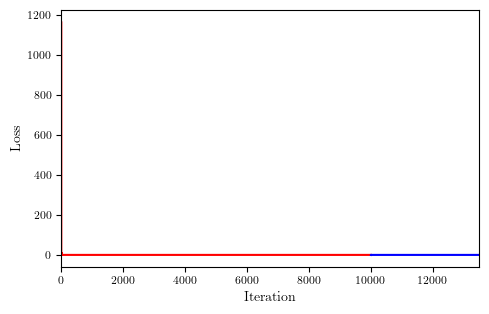

In [28]:
#打印误差随迭代次数的变化
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()
print('Train Loss: {:4f}'.format(trainloss[-1]))

# print(trainloss.shape)
indices=list(range(len(trainloss)))
plt.figure()
plt.plot(indices[:nIter],trainloss[:nIter],color='red')
plt.plot(indices[nIter:],trainloss[nIter:],color='blue')

plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlim([0,max(indices)]) # 设置x轴的范围
# plt.ylim([0,1]) # 设置y轴的范围

plt.show()

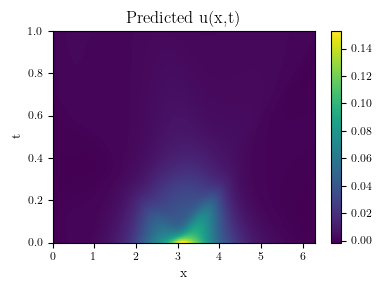

In [29]:
#可视化结果，绘图数据为pred，代表预测值
plt.figure(figsize=(4,3))
plt.imshow(u_pred, extent=[0,np.pi*2,1,0], aspect='auto') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
plt.gca().invert_yaxis() # 翻转y轴
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout() #自动调整子图参数，使得子图之间的间距适当，这样图像看起来更加整洁。
plt.show()

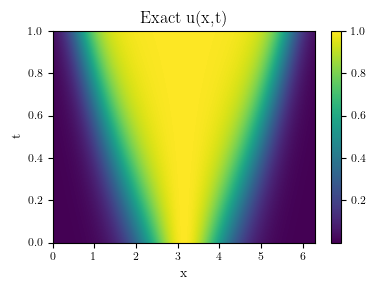

In [30]:
#可视化结果，绘图数据为u，代表解析解
plt.figure(figsize=(4,3))
plt.imshow(u_real, extent=[0,np.pi*2,1,0], aspect='auto') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
plt.gca().invert_yaxis() # 翻转y轴
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.show()

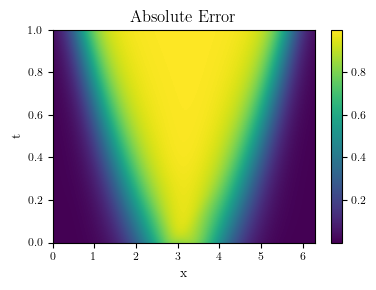

In [31]:
#可视化结果，绘图数据为np.abs(pred - u)，代表预测值与解析解的绝对误差
plt.figure(figsize=(4,3))
plt.imshow(np.abs(u_pred - u_real), extent=[0,np.pi*2,1,0], aspect='auto') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
plt.gca().invert_yaxis() # 翻转y轴
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.show()

## Visualizations

In [32]:
#进行插值，准备绘制详细预测值
x = np.linspace(0, 2*np.pi, 301)
t = np.linspace(0, 1, 101)

X, T = np.meshgrid(x,t)

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_test, u_pred.flatten(), (X,T), method='cubic')


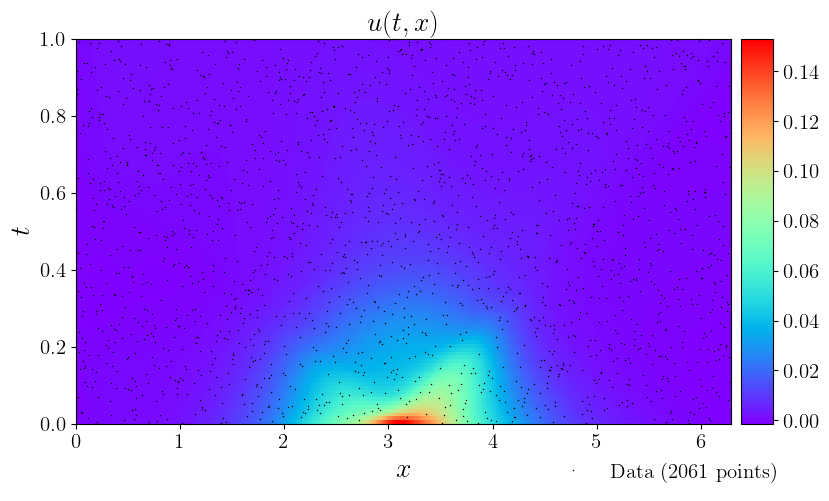

In [33]:
###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred, interpolation='nearest', cmap='rainbow', 
              extent=[x.min(), x.max(), t.min(), t.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图

ax.plot(
    X_train[:,0], 
    X_train[:,1], 
    'kx', label = 'Data (%d points)' % (X_train.shape[0]), 
    markersize = 0.4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  


#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$x$', size=20)
ax.set_ylabel('$t$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

## Visualizations

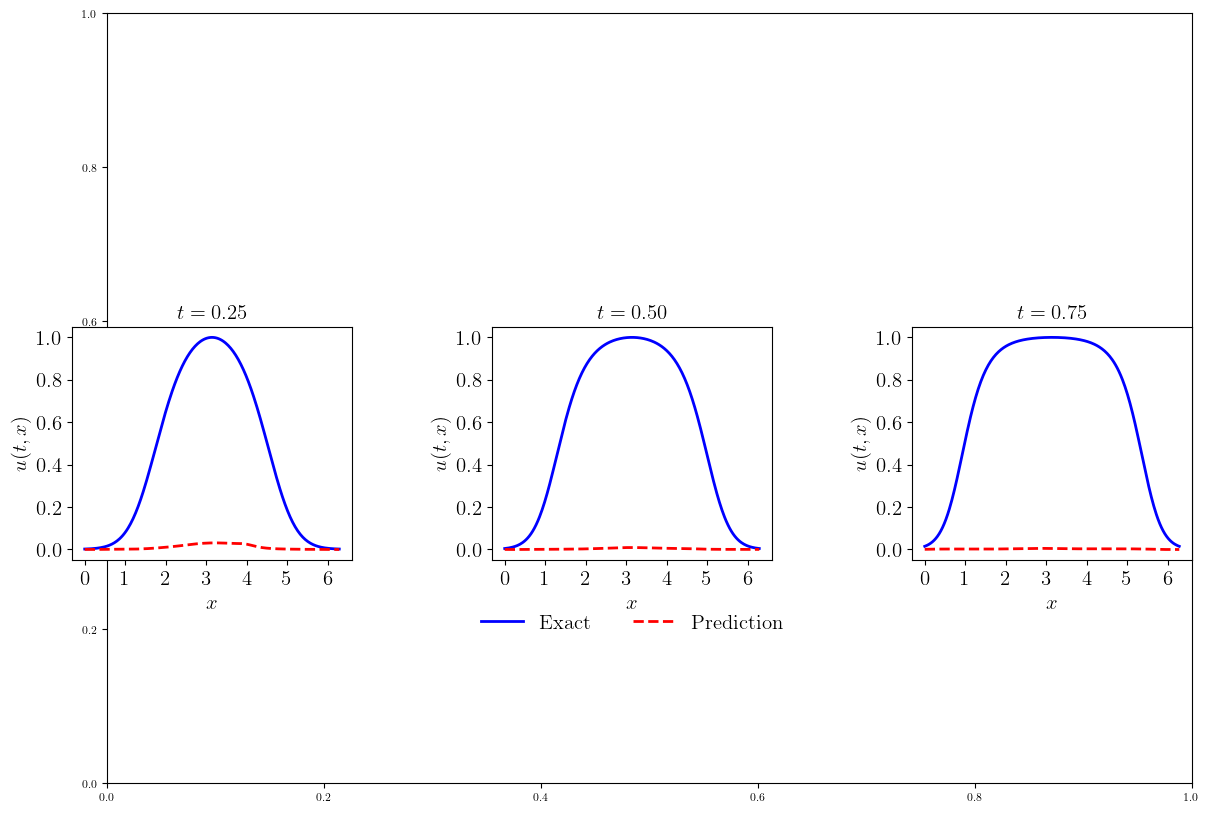

In [34]:
####### Row 1: u(t,x) slices ################## 


fig = plt.figure(figsize=(14, 10))#这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽14英寸高10英寸
ax = fig.add_subplot(111)#在图形的1*1网格的第一个位置添加一个子图

gs1 = gridspec.GridSpec(1, 3)#创建一个1×3的网络，用于存放子图
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)  #更新该网络的参数，第一个表示子图的顶部位置为0.567，第二个参数表示子图的底部位置为0.33，第三个表示子图左侧的位置为0.1，第四个参数表示子图的右侧位置为0.9，第五个参数表示子图之间的宽度为0.5

ax = plt.subplot(gs1[0, 0])  #在gs1[0,0]指定的位置，也就是网格的第一行第一列，创建了第一个子图，并将返回的axes对象赋值给ax。
#绘制了两条线，一条表示精确值，一条表示预测值
ax.plot(x,u_real[25,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值     
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$')    #设置子图的y轴的标签为u(t,x)
ax.set_title('$t = 0.25$', fontsize = 15) #设置子图的标题为t=0.25，fontsize=10表示字体大小为15
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第一个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第一个子图的y轴的范围为[-1.1,1.1]
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 1]) #在gs1[0,1]指定的位置，也就是网格的第一行第二列，创建了第二个子图，并将返回的axes对象赋值给ax。
ax.plot(x,u_real[50,:], 'b-', linewidth = 2, label = 'Exact')   #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值    
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第二个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第二个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.50$', fontsize = 15) #设置子图的标题为t=0.50，fontsize=15表示字体大小为15
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)#设置子图的图例，loc='upper center'表示图例的位置是上方中间，bbox_to_anchor=(0.5, -0.15)表示图例的位置是在子图的中间下方0.15的位置，ncol=5表示图例的列数为5，frameon=False表示不显示图例的边框；最后一个参数设置图例属性，接受字典作为参数，这里表示将图例的字体大小设置为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。
    
ax = plt.subplot(gs1[0, 2]) #在gs1[0,2]指定的位置，也就是网格的第一行第三列，创建了第三个子图，并将返回的axes对象赋值给ax。
ax.plot(x,u_real[75,:], 'b-', linewidth = 2, label = 'Exact')  #第一个参数表示x轴上的坐标；第二个参数表示y轴上的坐标；第三个参数b-表示蓝色的实线；linewidth表示线的宽度为2；label表示线的标签，这条线表示实际值
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction') #同上，红色虚线表示预测值
ax.set_xlabel('$x$') #设置子图的x轴的标签为x
ax.set_ylabel('$u(t,x)$') #设置子图的y轴的标签为u(t,x)
# ax.axis('square') #设置子图的纵横比为1，即正方形的区域
# ax.set_xlim([-1.1,1.1]) #设置第三个子图的x轴的范围为[-1.1,1.1]
# ax.set_ylim([-1.1,1.1]) #设置第三个子图的y轴的范围为[-1.1,1.1]
ax.set_title('$t = 0.75$', fontsize = 15) #设置子图的标题为t=0.75，fontsize=15表示字体大小为15
#将图形的标题、x轴标签、y轴标签以及所有的x轴和y轴的刻度标签的字体大小设置为15
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
#循环上，`ax.title`、`ax.xaxis.label`、`ax.yaxis.label` 分别代表图形的标题、x轴标签和y轴标签。`ax.get_xticklabels()` 和 `ax.get_yticklabels()` 方法返回的是一个包含所有x轴和y轴刻度标签的列表。
#`item.set_fontsize(15)` 是用来设置列表中的元素item的字体大小的。

plt.show() #显示所有打开的图形的函数